In [1]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

In [12]:
# BERT imports
import torch
from transformers import BertConfig
from transformers import BertModel
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [13]:
# specify CPU or GPU as device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'device = {device}')

device = cpu


In [14]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


### Add special tokens to sequences

In [15]:
# add special tokens to queries and documents
queries = ["[CLS] " + query + " [SEP]" for query in df['query']]
documents =  ["[CLS] " + query + " [SEP]" for query in df['documents']]
print("Example of query:\n", queries[0])
print("\nExample of document:\n", documents[0])


Example of query:
 [CLS] lede musikalsk personale [SEP]

Example of document:
 [CLS] Tildele og forvalte personaleopgaver på områder såsom instrumentering, bearbejdning, reproduktion af musik og stemmetræning. [SEP]


### Load BERT tokenizer
The BERT tokenizer is very storage efficient way of splitting a sequence into words - or rather tokens of subwords. The tokenizer uses WordPiece which uses subwords. That is splitting words into multiple words in order to keep the vocabulary smaller. That way, the vocabulary does not need to keep both: "boy" and "boys" but only "boy" and "s" where "s" can be used in many other cases.

In [16]:
# Tokenize with BERT tokenizer
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

# Tokenize queries and documents
tokenized_texts = [tokenizer.tokenize(sent) for sent in queries]
tokenized_docs = [tokenizer.tokenize(doc) for doc in documents]

print(f'Tokenized first sentence: \n {tokenized_texts[0]}')
print (f'\nTokenized first document: \n {tokenized_docs[0]}')

Tokenized first sentence: 
 ['[CLS]', 'lede', 'musikalsk', 'personale', '[SEP]']

Tokenized first document: 
 ['[CLS]', 'tildele', 'og', 'forvalt', '##e', 'personale', '##opgaver', 'pa', 'om', '##rad', '##er', 'sas', '##om', 'instrumenter', '##ing', ',', 'bearbejdning', ',', 'reproduktion', 'af', 'musik', 'og', 'stemme', '##træning', '.', '[SEP]']


In [17]:
# Set the maximum query length. 
MAX_LEN_Q = 24

# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
q_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
q_input_ids = pad_sequences(q_input_ids, maxlen=MAX_LEN_Q, dtype="long", truncating="post", padding="post")
print(f'Shape of query ids:\n q_input_ids.shape = {q_input_ids.shape}')


# Create query attention masks
q_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in q_input_ids:
  seq_mask = [float(i>0) for i in seq]
  q_attention_masks.append(seq_mask)

print(f'Shape of query attention mask:\n q_attention_masks = {np.shape(q_attention_masks)}')

assert q_input_ids.shape == np.shape(q_attention_masks), 'dimensions of q_input_ids and q_attention_mask do not match' 

Shape of query ids:
 q_input_ids.shape = (13485, 24)
Shape of query attention mask:
 q_attention_masks = (13485, 24)


In [18]:
q_input_ids[0]

array([    2,  5657, 16302,  3730,     3,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [19]:
# Set the maximum document length. 
MAX_LEN_DOC = 128
# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
d_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_docs]
d_input_ids = pad_sequences(d_input_ids, maxlen=MAX_LEN_DOC, dtype="long", truncating="post", padding="post")
print(f'Shape of input_ids.shape: {d_input_ids.shape}')


# Create attention masks for documents
d_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in d_input_ids:
  seq_mask = [float(i>0) for i in seq]
  d_attention_masks.append(seq_mask)

print(f'Shape of d_attention_masks: {np.shape(d_attention_masks)}')

assert d_input_ids.shape == np.shape(d_attention_masks), 'dimensions of document d_input_ids and d_attention_mask do not match' 

Shape of input_ids.shape: (13485, 128)
Shape of d_attention_masks: (13485, 128)


## Split into training and test datasets

In [130]:
# spliting index
index_spilt = 200#00

# training data
train_q_input_ids = q_input_ids[:index_spilt] 
train_d_input_ids = d_input_ids[:index_spilt] 

train_q_attention_masks = q_attention_masks[:index_spilt] 
train_d_attention_masks = d_attention_masks[:index_spilt] 

# create labels (all are correct)
train_labels = torch.ones(train_q_input_ids.shape[0])


# validation data
val_q_input_ids = q_input_ids[index_spilt:index_spilt+101] 
val_d_input_ids = d_input_ids[index_spilt:index_spilt+101] 

val_q_attention_masks = q_attention_masks[index_spilt:index_spilt+101] 
val_d_attention_masks = d_attention_masks[index_spilt:index_spilt+101] 

val_labels = torch.ones(val_q_input_ids.shape[0])


## Create Pytorch DataLoader

In [132]:
batch_size = 50
dataset = TensorDataset(torch.tensor(train_q_input_ids), 
                        torch.tensor(train_d_input_ids), 
                        torch.tensor(train_q_attention_masks), 
                        torch.tensor(train_d_attention_masks), 
                        train_labels)

loader = DataLoader(
    dataset,
    batch_size=batch_size
)

#for batch_idx, (x, y, z, a, l) in enumerate(loader):
#    print(x.shape, y.shape, z.shape, a.shape, l.shape)

In [133]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Create the DataLoader for our training set
train_data = TensorDataset(torch.tensor(train_q_input_ids), 
                        torch.tensor(train_d_input_ids), 
                        torch.tensor(train_q_attention_masks), 
                        torch.tensor(train_d_attention_masks), 
                        train_labels)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(torch.tensor(val_q_input_ids), 
                        torch.tensor(val_d_input_ids), 
                        torch.tensor(val_q_attention_masks), 
                        torch.tensor(val_d_attention_masks), 
                        val_labels)

val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Import BERT base model (Danish)
Queries and documents have now been tokenized to the vocabolary

In [140]:
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'

from transformers import BertConfig
from transformers import BertModel

config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)


class MyColBERT(nn.Module):
      def __init__(self):
            super(MyColBERT, self).__init__()
            self.bert = bert_base 
            ### New layers:
            self.linear1 = nn.Linear(768, 32) 

            # Freeze parameters of BERT Base as I only will train last layer
            for param in self.bert.parameters():
                  param.requires_grad = False
          

      def forward(self, q_ids, q_mask, d_ids, d_mask, q_index):
            query_embeddings= self.bert(q_ids[q_index:q_index+1], attention_mask=q_mask[q_index:q_index+1])[0] 
            query_embeddings = self.linear1(query_embeddings)
            query_embeddings = F.normalize(query_embeddings, p=2.0, dim=1, eps=1e-12, out=None)
            #query_embeddings = F.softmax(query_embeddings, dim=1)

            doc_embeddings = self.bert(d_ids, attention_mask=d_mask)[0]
            doc_embeddings = self.linear1(doc_embeddings)
            doc_embeddings = F.normalize(doc_embeddings, p=2.0, dim=1, eps=1e-12, out=None)
            #doc_embeddings = F.softmax(doc_embeddings, dim=1)

            # Compute score for a query against all documents (in batch) 
#            score = F.softmax(self.MaxSim(query_embeddings[q_index], doc_embeddings), dim=0)
            score = self.MaxSim(query_embeddings[q_index], doc_embeddings)

            return score

      
      def MaxSim(self, q, D):
            '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
                Return a tensor of the query's similarity scores to all documents in D.'''

            # repeat q for faster matrix multiplication (faster than loop)
            batch_size=D.shape[0]
            q_X = q.repeat(batch_size, 1, 1)

            # multiply the same query q against all documents (in D)
            batch_mm = torch.bmm(q_X, D.permute(0,2,1))

            maks, maks_id = torch.max(batch_mm, dim=2) # should be (batch_size, 24)

            # Sum over maximum values --> return vector of length len(D)
            S_qD = torch.sum(maks, dim=1)

            return S_qD
                  

In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. In my implementation of ColBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [batch_{size} \times 24 \times 32] \\
    dim(E_d) = [batch_{size} \times 128 \times 32]
\end{align*}


The relevancy score, MaxSim, is defined as follows:

$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

## Define criterion
$$ L(q, d_i) = \frac{exp(MaxSim(q, d_i))}{\sum_{j \in ||D||} exp(MaxSim(q, d_j))} = \frac{exp( MaxSim(q, D)[i] )}{\sum exp( MaxSim(q, D) )}$$

# Training / Fine-tuning of model 

In [141]:
def my_softmax(similarity_scores):
    maks_score, maks_id = torch.max(similarity_scores, dim=0)
    return torch.exp(maks_score) / torch.sum(torch.exp(similarity_scores))

In [142]:
## Define model, loss function (criterion) and optimizer
model = MyColBERT()
model.to(torch.device(device))
#criterion = my_softmax
#criterion = nn.CrossEntropyLoss() ## If required define your own criterion #TODO:
criterion = nn.MSELoss() ## If required define your own criterion #TODO:


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))  # alternative: optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

#print(model)

### Test on simple dataset:

In [99]:
step = 0
stide_len = 10 #batch_size # 100 or 10 for debugging

q_index = 1


q_id    = torch.tensor(q_input_ids[step:step+stide_len]).to(torch.device(device)).to(torch.int64)
d_id    = torch.tensor(d_input_ids[step:step+stide_len]).to(torch.device(device)).to(torch.int64)
q_mask  = torch.tensor(np.array(q_attention_masks[step:step+stide_len])).to(torch.device(device)).to(torch.int64)
d_mask  = torch.tensor(np.array(d_attention_masks[step:step+stide_len])).to(torch.device(device)).to(torch.int64)

#%% Apply model to finde score of query q_index against stide_len ducuments
 
scores = model(q_ids=q_id, q_mask=q_mask, d_ids=d_id, d_mask=d_mask, q_index=0)
scores.to(torch.device(device))

tensor([ -6.6696, -15.7458, -15.7305, -12.5499, -11.3765, -15.0673, -11.5651,
        -13.3800, -10.5979, -11.4120], grad_fn=<SumBackward1>)

In [91]:
label = torch.zeros(stide_len)
label[q_index] = 1
criterion(scores, target=label)

tensor(1091.2253, grad_fn=<MseLossBackward>)

In [71]:
 for i, data in enumerate(df, 0):


In [143]:
from torch.autograd import Variable

num_epoch = 2 #15

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []


for epoch in range(num_epoch):  # loop over the dataset multiple times

    train_running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        
        # get the inputs
        q_ids, d_ids, q_masks, d_masks, labels = data
        
        # send to gpu (or cpu)
        q_ids, d_ids, q_masks, d_masks = q_ids.to(torch.int64).to(device), d_ids.to(torch.int64).to(device), q_masks.to(torch.int64).to(device), d_masks.to(torch.int64).to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        ## Forward
        q_index = 0
        scores = model(q_ids=q_ids, q_mask=q_masks, d_ids=d_ids, d_mask=d_masks, q_index=q_index)

        # Define labels
        labels = torch.zeros(batch_size)
        labels[q_index] = 1        

        # Compute score for all q and D in one output
        loss = criterion(scores, target=labels)        
        
        ## backward
        loss.backward()
        
        # optimize
        optimizer.step()
        
        # print statistics
        train_running_loss += loss.item() 
        train_iter.append(i)
        train_loss.append(train_running_loss/len(data))

        if i % 10 == 0:    # print every 1000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / 1000))
            train_running_loss = 0.0

        

    
    val_running_loss = 0.0
    model.eval()
    for i, data in enumerate(val_dataloader, 0):
        
        # get the inputs
        q_ids, d_ids, q_masks, d_masks, labels = data
        
        # send to gpu (or cpu)
        q_ids, d_ids, q_masks, d_masks = q_ids.to(torch.int64).to(device), d_ids.to(torch.int64).to(device), q_masks.to(torch.int64).to(device), d_masks.to(torch.int64).to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        ## Forward
        q_index = 0
        scores = model(q_ids=q_ids, q_mask=q_masks, d_ids=d_ids, d_mask=d_masks, q_index=q_index)


        # Define labels
        labels = torch.zeros(batch_size)
        labels[q_index] = 1        

        # Compute score for all q and D in one output
        loss = criterion(scores, target=labels)               

        ## backward
        loss.backward()

        # optimize
        optimizer.step()

        # print statistics
        val_running_loss += loss.item() 
        valid_iter.append(i)
        valid_loss.append(val_running_loss/len(data))

        if i % 10 == 0:    # print every 1000 mini-batches
            print('[%d, %5d] validation loss: %.3f' %
                  (epoch + 1, i + 1, val_running_loss / 1000))
            val_running_loss = 0.0
     
        

print('Finished Training')

[1,     1] training loss: 0.090
[1,     1] validation loss: 0.087


C:\Users\B075420\Anaconda3\envs\colbert\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,     1] training loss: 0.036
[2,     1] validation loss: 0.041
Finished Training


In [138]:
train_loss
#valid_loss
valid_iter

[0, 1, 2]

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

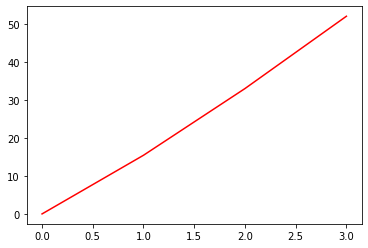

In [139]:
epoch = np.arange(len(train_iter))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [ ]:
#for batch in train_dataloader:
#    print(batch.item())